In [1]:
# # Reload all modules every time before executing code
# %load_ext autoreload
# %autoreload 2  

In [2]:
%matplotlib inline 
import pickle
import json
from pathlib import Path
from typing import Dict, Union

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from sklearn.metrics import classification_report, accuracy_score

In [3]:
# Import project-specific custom modules.

from utils import set_seed, Config, plot_tsne, plot_loss, plot_accuracy
from utils.interpretability import compute_average_saliency_by_class, plot_saliency_radar
from data_loader import MultiOmicsDataset, create_dataloaders

from models import MultiOmicsClassifier 
from trainers import BaseTrainer, CallbackTrainer
from losses import MultiOmicsLoss
from callbacks import LossRecorderCallback, AccuracyRecorderCallback
from callbacks import TSNERecorderCallback, AttentionLoggerCallback
    


### 1. Run pytest

In [4]:
%%bash
pytest -v

============================= test session starts ==============================
collecting ... collected 8 items

tests/test_02_model_components.py::test_vae_forward PASSED               [ 12%]
tests/test_02_model_components.py::test_mirna_vae_forward PASSED         [ 25%]
tests/test_02_model_components.py::test_mini_convnext PASSED             [ 37%]
tests/test_02_model_components.py::test_transformer_fusion PASSED        [ 50%]
tests/test_02_model_components.py::test_fusion_classifier PASSED         [ 62%]
tests/test_interpretability/test_saliency_aggregate.py::test_compute_average_saliency_by_class PASSED [ 75%]
tests/test_interpretability/test_saliency_core.py::test_saliency_computation_for_rna PASSED [ 87%]
tests/test_interpretability/test_saliency_plot.py::test_plot_saliency_radar_runs_without_error PASSED [100%]

============================== 8 passed in 0.83s ===============================


In [5]:
# Project-specific custom functions

def extract_latent(outputs):
    """Example: Extract latent representation from your specific model outputs"""
    return outputs['latent_rep']  # Replace with your actual latent key

def setup_logging_path(base_dir: Union[str, Path]) -> Dict[str, Path]:
    """
    Initialize logging directory and return standardized file paths.
    """
    base_path = Path(base_dir)
    base_path.mkdir(parents=True, exist_ok=True)

    return {
        "loss": base_path/"loss_history.json",
        "acc": base_path/"accuracy_history.json",
        "tsne": base_path/"tsne_results.pkl", 
        "att": base_path/"attention_weights.pkl"
    }


In [6]:
def print_training_parameters(trainer, include_model_info=False, include_optimizer_state=False):
    """Extracts all relevant training parameters in a structured dictionary.
    
    Args:
        trainer: BaseTrainer instance
        include_model_info: Whether to include model architecture details
        include_optimizer_state: Whether to include optimizer state details
        
    Returns:
        Dictionary containing all training parameters
    """
    params = {
        "training": {
            "device": str(trainer.device),
        },
        "loss": {
            "type": type(trainer.loss_fn).__name__,
            "beta": getattr(trainer.loss_fn, 'target_beta', None),
            "use_focal": getattr(trainer.loss_fn, 'use_focal', None),
            "focal_gamma": getattr(trainer.loss_fn, 'focal_gamma', None),
            "label_smoothing": getattr(trainer.loss_fn, 'label_smoothing', None),
            "kl_epsilon": getattr(trainer.loss_fn, 'kl_epsilon', None)
        },
        "optimizer": {
            "type": type(trainer.optimizer).__name__,
            "lr": trainer.optimizer.param_groups[0]['lr'],
            "betas": trainer.optimizer.param_groups[0].get('betas', None),
            "eps": trainer.optimizer.param_groups[0].get('eps', None),
            "weight_decay": trainer.optimizer.param_groups[0].get('weight_decay', None)
        }
    }
    
    if include_model_info:
        params["model"] = {
            "type": type(trainer.model).__name__,
            "total_parameters": sum(p.numel() for p in trainer.model.parameters()),
            "trainable_parameters": sum(p.numel() for p in trainer.model.parameters() 
                                      if p.requires_grad),
            "architecture": str(trainer.model)  # This shows the model structure
        }
    
    if include_optimizer_state:
        params["optimizer"]["state"] = {
            "momentum_buffer": any('momentum_buffer' in p for p in trainer.optimizer.state.values())
        }

    
    return params

    
# params = print_training_parameters(trainer)
# print(json.dumps(params, indent=4))

In [7]:
from sklearn.metrics import balanced_accuracy_score, f1_score, classification_report
from collections import Counter
import json
import warnings
from sklearn.exceptions import UndefinedMetricWarning

def evaluate_and_log_model(
    trainer, 
    dataloader, 
    get_training_parameters_fn=print_training_parameters, 
    verbose=True,
    seed=None
) -> dict:
    """
    Evaluates model on test data with comprehensive metrics.
    
    Args:
        trainer: Trainer object with predict() method
        dataloader: Test dataloader
        get_training_parameters_fn: Function to extract training params
        verbose: Whether to print results
        
    Returns:
        Dictionary containing accuracy, balanced accuracy, F1, classification report,
        class distribution, and training parameters.
    """
    if seed is not None:
        set_seed(seed)
        if verbose:
            print(f"🔒 Random seed set to {seed}")
        
    preds, targets = trainer.predict(dataloader)
    y_true, y_pred = targets.numpy(), preds.numpy()

    with warnings.catch_warnings():
        warnings.simplefilter('ignore', UndefinedMetricWarning)
        metrics = {
            'accuracy': accuracy_score(y_true, y_pred),
            'balanced_accuracy': balanced_accuracy_score(y_true, y_pred),
            'f1_macro': f1_score(y_true, y_pred, average='macro', zero_division=0),
            'class_report': classification_report(y_true, y_pred, output_dict=True, zero_division=0),
            'class_distribution': {
                'true': dict(Counter(y_true)),
                'pred': dict(Counter(y_pred))
            },
            'params': get_training_parameters_fn(trainer)
        }

    if verbose:
        print(f"\nEvaluation Metrics:")
        print(f"Accuracy: {metrics['accuracy']:.4f}")
        print(f"Balanced Accuracy: {metrics['balanced_accuracy']:.4f}")
        print(f"Macro F1: {metrics['f1_macro']:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_true, y_pred, zero_division=0))
        print("\nTraining Parameters:")
        # print(json.dumps(metrics['params'], indent=2))
        print(json.dumps(metrics['params'], indent=2).replace('\\n', '\n').replace('\\"', '"'))

    
    



In [8]:
# Generate dataloaders|
set_seed(42)
config = Config.from_yaml("configs/data_config.yaml")

dataset = MultiOmicsDataset(config)
dataloaders = create_dataloaders(dataset, config)



In [9]:
log_paths_1 = setup_logging_path("logs/experiment_1")

class_weights = None
latent_dim = 128

# Loss function
loss_fn = MultiOmicsLoss(
    beta=0.15,               # Target KL weight
    use_focal=False, 
    focal_gamma=None
)


# Instantiate model
multiomics_model_1 = MultiOmicsClassifier(
    mirna_dim=1046,
    rna_exp_dim=13054,
    methy_shape=(50, 100),
    latent_dim=latent_dim,
    num_classes=5
)

optimizer=torch.optim.AdamW(multiomics_model_1.parameters(), lr=8e-5, weight_decay=0.005)

callbacks = [
    LossRecorderCallback(save_path=log_paths_1["loss"]),
    AccuracyRecorderCallback(save_path=log_paths_1["acc"], debug=False),
    TSNERecorderCallback(
        val_loader=dataloaders['val'],
        device='cuda',
        save_path=log_paths_1["tsne"]
    ),
    AttentionLoggerCallback(
        save_path=log_paths_1["att"],
        modality_names=["methy", "mirna", "rna"]
    )
]



# Start training
trainer_cb_1 = CallbackTrainer(
    model=multiomics_model_1,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device='cuda', 
    callbacks=callbacks,
    seed=42
)

trainer_cb_1.fit(train_loader=dataloaders['train'], val_loader=dataloaders['val'], epochs=50)

Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  3.27it/s, loss=2.14]


Epoch 1/50 | Train Loss: 2.2753


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.33it/s]

Epoch 1/50 | Val Loss: 4.6709


✅ Val Accuracy: 0.4455


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.73it/s, loss=1.81]


step    10 | loss: 2.0753 | ce: 1.4072 | kl: 58.4733 | beta: 0.0114
Epoch 2/50 | Train Loss: 1.9885


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.35it/s]

Epoch 2/50 | Val Loss: 3.3456


✅ Val Accuracy: 0.4455


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.40it/s, loss=1.78]


Epoch 3/50 | Train Loss: 1.8719


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.46it/s]

Epoch 3/50 | Val Loss: 2.2856


✅ Val Accuracy: 0.4455


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.96it/s, loss=2.28]


Epoch 4/50 | Train Loss: 1.8698


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.45it/s]

Epoch 4/50 | Val Loss: 1.7788


✅ Val Accuracy: 0.4818


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.55it/s, loss=1.52]


step    30 | loss: 1.6983 | ce: 1.2274 | kl: 40.8341 | beta: 0.0115
Epoch 5/50 | Train Loss: 1.6316


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.25it/s]

Epoch 5/50 | Val Loss: 1.6650


✅ Val Accuracy: 0.5636
🚩 End of epoch 5 — Logging attention


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.76it/s, loss=1.52]


step    40 | loss: 1.5229 | ce: 1.0868 | kl: 37.6470 | beta: 0.0116
Epoch 6/50 | Train Loss: 1.5743


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.45it/s]

Epoch 6/50 | Val Loss: 1.5627


✅ Val Accuracy: 0.6091


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.89it/s, loss=1.64]


Epoch 7/50 | Train Loss: 1.5061


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.30it/s]

Epoch 7/50 | Val Loss: 1.4475


✅ Val Accuracy: 0.6091


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.08it/s, loss=1.36]


step    50 | loss: 1.3501 | ce: 0.9335 | kl: 35.7902 | beta: 0.0116
Epoch 8/50 | Train Loss: 1.3923


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.60it/s]

Epoch 8/50 | Val Loss: 1.4085


✅ Val Accuracy: 0.7727


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.82it/s, loss=1.37]


step    60 | loss: 1.1963 | ce: 0.7716 | kl: 36.3275 | beta: 0.0117
Epoch 9/50 | Train Loss: 1.2931


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.39it/s]

Epoch 9/50 | Val Loss: 1.6930


✅ Val Accuracy: 0.6000


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.35it/s, loss=0.941]


Epoch 10/50 | Train Loss: 1.1179


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.25it/s]

Epoch 10/50 | Val Loss: 1.3882


✅ Val Accuracy: 0.7727
🚩 End of epoch 10 — Logging attention


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.32it/s, loss=0.954]


Epoch 11/50 | Train Loss: 1.0393


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.59it/s]

Epoch 11/50 | Val Loss: 1.2097


✅ Val Accuracy: 0.7273


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.35it/s, loss=0.829]


step    80 | loss: 0.9386 | ce: 0.5341 | kl: 34.2729 | beta: 0.0118
Epoch 12/50 | Train Loss: 0.9665


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.16it/s]

Epoch 12/50 | Val Loss: 1.4035


✅ Val Accuracy: 0.6091


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.74it/s, loss=1.3]


Epoch 13/50 | Train Loss: 0.9960


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.06it/s]

Epoch 13/50 | Val Loss: 1.0686


✅ Val Accuracy: 0.7727


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.31it/s, loss=0.863]


Epoch 14/50 | Train Loss: 0.8916


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.19it/s]

Epoch 14/50 | Val Loss: 1.0998


✅ Val Accuracy: 0.7909


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.27it/s, loss=0.762]


step   100 | loss: 0.8643 | ce: 0.4720 | kl: 32.9354 | beta: 0.0119
Epoch 15/50 | Train Loss: 0.8230


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.18it/s]

Epoch 15/50 | Val Loss: 1.0400


✅ Val Accuracy: 0.7727
🚩 End of epoch 15 — Logging attention


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.16it/s, loss=0.774]


step   110 | loss: 0.7743 | ce: 0.3711 | kl: 33.6995 | beta: 0.0120
Epoch 16/50 | Train Loss: 0.8101


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.30it/s]

Epoch 16/50 | Val Loss: 1.7555


✅ Val Accuracy: 0.5818


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.23it/s, loss=0.935]


Epoch 17/50 | Train Loss: 0.7932


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.21it/s]

Epoch 17/50 | Val Loss: 0.9953


✅ Val Accuracy: 0.7727


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.29it/s, loss=0.678]


step   120 | loss: 0.7802 | ce: 0.3888 | kl: 32.5648 | beta: 0.0120
Epoch 18/50 | Train Loss: 0.7106


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.13it/s]

Epoch 18/50 | Val Loss: 1.8305


✅ Val Accuracy: 0.5273


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.29it/s, loss=0.863]


step   130 | loss: 0.6369 | ce: 0.2928 | kl: 28.4949 | beta: 0.0121
Epoch 19/50 | Train Loss: 0.7179


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.31it/s]

Epoch 19/50 | Val Loss: 0.9740


✅ Val Accuracy: 0.7545


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.14it/s, loss=0.634]


Epoch 20/50 | Train Loss: 0.6538


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.65it/s]

Epoch 20/50 | Val Loss: 0.9267


✅ Val Accuracy: 0.7909
🚩 End of epoch 20 — Logging attention


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.43it/s, loss=0.761]


Epoch 21/50 | Train Loss: 0.6164


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.07it/s]

Epoch 21/50 | Val Loss: 0.9700


✅ Val Accuracy: 0.7273


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.00it/s, loss=0.675]


step   150 | loss: 0.5303 | ce: 0.2156 | kl: 25.8267 | beta: 0.0122
Epoch 22/50 | Train Loss: 0.6218


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.84it/s]

Epoch 22/50 | Val Loss: 0.9579


✅ Val Accuracy: 0.8000


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.01it/s, loss=0.565]


Epoch 23/50 | Train Loss: 0.5984


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.33it/s]

Epoch 23/50 | Val Loss: 1.1508


✅ Val Accuracy: 0.5636


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.67it/s, loss=0.641]


Epoch 24/50 | Train Loss: 0.5689


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.21it/s]

Epoch 24/50 | Val Loss: 0.9787


✅ Val Accuracy: 0.7182


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.18it/s, loss=0.83]


step   170 | loss: 0.5204 | ce: 0.1911 | kl: 26.7672 | beta: 0.0123
Epoch 25/50 | Train Loss: 0.5855


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.34it/s]

Epoch 25/50 | Val Loss: 0.7881


✅ Val Accuracy: 0.8364
🚩 End of epoch 25 — Logging attention


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.17it/s, loss=0.987]


step   180 | loss: 0.9869 | ce: 0.6974 | kl: 23.4276 | beta: 0.0124
Epoch 26/50 | Train Loss: 0.6831


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.18it/s]

Epoch 26/50 | Val Loss: 0.8061


✅ Val Accuracy: 0.8182


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.40it/s, loss=0.471]


Epoch 27/50 | Train Loss: 0.5389


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.17it/s]

Epoch 27/50 | Val Loss: 1.7372


✅ Val Accuracy: 0.5636


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.02it/s, loss=0.691]


step   190 | loss: 0.6261 | ce: 0.2689 | kl: 28.7819 | beta: 0.0124
Epoch 28/50 | Train Loss: 0.6097


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.27it/s]

Epoch 28/50 | Val Loss: 1.7799


✅ Val Accuracy: 0.5545


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.33it/s, loss=1.14]


step   200 | loss: 0.5064 | ce: 0.1760 | kl: 26.4913 | beta: 0.0125
Epoch 29/50 | Train Loss: 0.6267


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.27it/s]

Epoch 29/50 | Val Loss: 1.1655


✅ Val Accuracy: 0.6909


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.74it/s, loss=1.42]


Epoch 30/50 | Train Loss: 0.6923


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.14it/s]

Epoch 30/50 | Val Loss: 1.9002


✅ Val Accuracy: 0.5455
🚩 End of epoch 30 — Logging attention


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.29it/s, loss=1.05]


Epoch 31/50 | Train Loss: 0.6336


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.14it/s]

Epoch 31/50 | Val Loss: 1.3301


✅ Val Accuracy: 0.6273


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.13it/s, loss=0.728]


step   220 | loss: 0.6647 | ce: 0.3257 | kl: 26.9413 | beta: 0.0126
Epoch 32/50 | Train Loss: 0.5919


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.05it/s]

Epoch 32/50 | Val Loss: 1.0405


✅ Val Accuracy: 0.7000


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.24it/s, loss=0.362]


Epoch 33/50 | Train Loss: 0.4533


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.17it/s]

Epoch 33/50 | Val Loss: 0.8504


✅ Val Accuracy: 0.7545


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.36it/s, loss=0.41]


Epoch 34/50 | Train Loss: 0.4477


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.06it/s]

Epoch 34/50 | Val Loss: 0.7983


✅ Val Accuracy: 0.8000


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.99it/s, loss=0.746]


step   240 | loss: 0.4049 | ce: 0.1160 | kl: 22.7434 | beta: 0.0127
Epoch 35/50 | Train Loss: 0.4996


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.88it/s]

Epoch 35/50 | Val Loss: 0.9059


✅ Val Accuracy: 0.7636
🚩 End of epoch 35 — Logging attention


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.27it/s, loss=0.346]


step   250 | loss: 0.3459 | ce: 0.0589 | kl: 22.4945 | beta: 0.0128
Epoch 36/50 | Train Loss: 0.4268


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.71it/s]

Epoch 36/50 | Val Loss: 0.6420


✅ Val Accuracy: 0.7818


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.40it/s, loss=0.569]


Epoch 37/50 | Train Loss: 0.4625


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.27it/s]

Epoch 37/50 | Val Loss: 0.6138


✅ Val Accuracy: 0.8091


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.59it/s, loss=0.356]


step   260 | loss: 0.4625 | ce: 0.1796 | kl: 22.0765 | beta: 0.0128
Epoch 38/50 | Train Loss: 0.4154


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.11it/s]

Epoch 38/50 | Val Loss: 0.7840


✅ Val Accuracy: 0.7909


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.37it/s, loss=0.565]


step   270 | loss: 0.3869 | ce: 0.1117 | kl: 21.3735 | beta: 0.0129
Epoch 39/50 | Train Loss: 0.4404


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.79it/s]

Epoch 39/50 | Val Loss: 0.9313


✅ Val Accuracy: 0.7091


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.33it/s, loss=0.615]


Epoch 40/50 | Train Loss: 0.4381


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.83it/s]

Epoch 40/50 | Val Loss: 0.8911


✅ Val Accuracy: 0.7818
🚩 End of epoch 40 — Logging attention


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.39it/s, loss=0.747]


Epoch 41/50 | Train Loss: 0.4544


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.78it/s]

Epoch 41/50 | Val Loss: 1.1558


✅ Val Accuracy: 0.6909


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.69it/s, loss=0.589]


step   290 | loss: 0.3965 | ce: 0.1256 | kl: 20.8468 | beta: 0.0130
Epoch 42/50 | Train Loss: 0.4841


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.30it/s]

Epoch 42/50 | Val Loss: 1.0185


✅ Val Accuracy: 0.7091


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.30it/s, loss=0.382]


Epoch 43/50 | Train Loss: 0.4216


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.28it/s]

Epoch 43/50 | Val Loss: 0.8556


✅ Val Accuracy: 0.7909


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.55it/s, loss=0.419]


Epoch 44/50 | Train Loss: 0.4004


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.16it/s]

Epoch 44/50 | Val Loss: 0.9106


✅ Val Accuracy: 0.7364


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.18it/s, loss=0.3]


step   310 | loss: 0.3572 | ce: 0.0779 | kl: 21.2966 | beta: 0.0131
Epoch 45/50 | Train Loss: 0.3478


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.05it/s]

Epoch 45/50 | Val Loss: 0.7983


✅ Val Accuracy: 0.7727
🚩 End of epoch 45 — Logging attention


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.76it/s, loss=0.315]


step   320 | loss: 0.3153 | ce: 0.0458 | kl: 20.4525 | beta: 0.0132
Epoch 46/50 | Train Loss: 0.3596


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.91it/s]

Epoch 46/50 | Val Loss: 0.7803


✅ Val Accuracy: 0.8000


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.80it/s, loss=0.814]


Epoch 47/50 | Train Loss: 0.4384


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.01it/s]

Epoch 47/50 | Val Loss: 0.8561


✅ Val Accuracy: 0.8182


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.12it/s, loss=1.2]


step   330 | loss: 0.3922 | ce: 0.1472 | kl: 18.5132 | beta: 0.0132
Epoch 48/50 | Train Loss: 0.5303


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.98it/s]

Epoch 48/50 | Val Loss: 0.9925


✅ Val Accuracy: 0.6636


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.32it/s, loss=1.02]


step   340 | loss: 0.4609 | ce: 0.1644 | kl: 22.3075 | beta: 0.0133
Epoch 49/50 | Train Loss: 0.5656


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.96it/s]

Epoch 49/50 | Val Loss: 1.1602


✅ Val Accuracy: 0.6909


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.12it/s, loss=0.589]


Epoch 50/50 | Train Loss: 0.4386


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.27it/s]

Epoch 50/50 | Val Loss: 1.0109


✅ Val Accuracy: 0.7273
🚩 End of epoch 50 — Logging attention
📦 Saved attention log to: logs/experiment_1/attention_weights.pkl


***************************************

The latent dim is 128
Class weights is None
***************************************

🔒 Random seed set to 42

Evaluation Metrics:
Accuracy: 0.6970
Balanced Accuracy: 0.6466
Macro F1: 0.6451

Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.83      0.75        29
           1       0.44      0.27      0.33        15
           2       0.82      1.00      0.90         9
           3       0.80      0.89      0.84         9
           4       1.00      0.25      0.40         4

    accuracy                           0.70        66
   macro avg       0.75      0.65      0.65        66
weighted avg       0.68      0.70      0.67        66


Training Parameters:
{
  "training": {
    "device": "cuda"
  },
  "loss": {
    "type": "MultiOmicsLoss",
    "beta": 0.15,
    "use_focal": false,
    "focal_gamma": null,
    "label_smoothing": 0.0,
    "kl_epsilon": 1e-08
  },
  "optimizer": {
    "ty

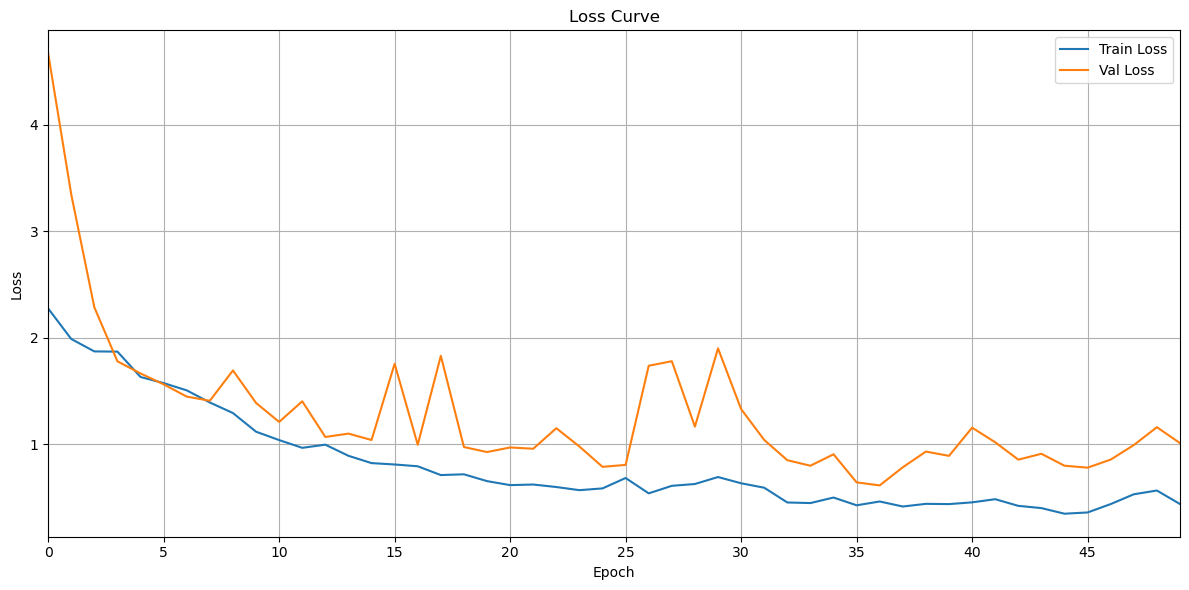

In [10]:
print("***************************************\n")
print(f'The latent dim is {latent_dim}')
print(f'Class weights is {class_weights}')

print("***************************************\n")
evaluate_and_log_model(trainer_cb_1 , dataloaders["test"], seed=42)
print("***************************************\n")
plot_loss(log_paths_1['loss'])

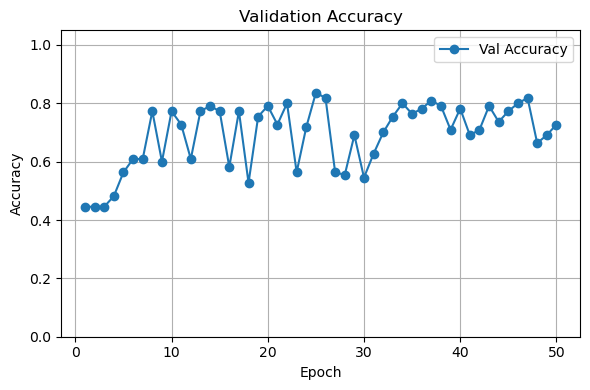

In [11]:
plot_accuracy(accuracy_path=log_paths_1['acc'])

In [12]:
log_paths_2 = setup_logging_path("logs/experiment_2")


class_weights = torch.tensor([1.0, 1.5, 1.0, 3.0, 3.5], device="cuda") 
latent_dim = 128

# Loss function
loss_fn = MultiOmicsLoss(
    beta=0.15,               # Target KL weight
    use_focal=True,
    focal_gamma=1.3,
    label_smoothing=0.05,
    annealing_steps=4000,
    class_weights=class_weights
)


# Instantiate model
multiomics_model_2 = MultiOmicsClassifier(
    mirna_dim=1046,
    rna_exp_dim=13054,
    methy_shape=(50, 100),
    latent_dim=latent_dim,
    num_classes=5
)

optimizer=torch.optim.AdamW(multiomics_model_2.parameters(), lr=6e-5, weight_decay=0.005)

callbacks = [
    LossRecorderCallback(save_path=log_paths_2["loss"]),
    AccuracyRecorderCallback(save_path=log_paths_2["acc"], debug=False),
    TSNERecorderCallback(
        val_loader=dataloaders['val'],
        device='cuda',
        save_path=log_paths_2["tsne"]
    ),
    AttentionLoggerCallback(
        save_path=log_paths_2["att"],
        modality_names=["methy", "mirna", "rna"]
    )
]



# Start training
trainer_cb_2 = CallbackTrainer(
    model=multiomics_model_2,
    optimizer=optimizer,
    loss_fn=loss_fn,
    device='cuda', 
    callbacks=callbacks,
    seed=42
)

trainer_cb_2.fit(train_loader=dataloaders['train'], val_loader=dataloaders['val'], epochs=50)

Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.02it/s, loss=2.96]


Epoch 1/50 | Train Loss: 3.0129


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.16it/s]

Epoch 1/50 | Val Loss: 4.1698


✅ Val Accuracy: 0.4545


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.74it/s, loss=2.55]


step    10 | loss: 2.7790 | ce: 2.0100 | kl: 66.8844 | beta: 0.0115
Epoch 2/50 | Train Loss: 2.6993


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.50it/s]

Epoch 2/50 | Val Loss: 3.4360


✅ Val Accuracy: 0.4818


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.70it/s, loss=2.58]


Epoch 3/50 | Train Loss: 2.5483


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.58it/s]

Epoch 3/50 | Val Loss: 2.8623


✅ Val Accuracy: 0.5364


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.26it/s, loss=3.43]


Epoch 4/50 | Train Loss: 2.5951


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.82it/s]

Epoch 4/50 | Val Loss: 2.5764


✅ Val Accuracy: 0.6091


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.63it/s, loss=1.88]


step    30 | loss: 2.3400 | ce: 1.7324 | kl: 51.6436 | beta: 0.0118
Epoch 5/50 | Train Loss: 2.2229


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.63it/s]

Epoch 5/50 | Val Loss: 2.3476


✅ Val Accuracy: 0.6364
🚩 End of epoch 5 — Logging attention


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.43it/s, loss=1.72]


step    40 | loss: 1.7167 | ce: 1.1685 | kl: 46.0586 | beta: 0.0119
Epoch 6/50 | Train Loss: 2.1033


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.96it/s]

Epoch 6/50 | Val Loss: 2.2406


✅ Val Accuracy: 0.7182


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.47it/s, loss=1.91]


Epoch 7/50 | Train Loss: 2.0685


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.45it/s]

Epoch 7/50 | Val Loss: 2.0526


✅ Val Accuracy: 0.7182


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.59it/s, loss=2.42]


step    50 | loss: 1.8738 | ce: 1.3245 | kl: 45.6221 | beta: 0.0120
Epoch 8/50 | Train Loss: 2.0586


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.39it/s]

Epoch 8/50 | Val Loss: 2.0333


✅ Val Accuracy: 0.7182


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.54it/s, loss=1.78]


step    60 | loss: 1.6575 | ce: 1.0929 | kl: 46.3593 | beta: 0.0122
Epoch 9/50 | Train Loss: 1.8263


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.71it/s]

Epoch 9/50 | Val Loss: 1.9275


✅ Val Accuracy: 0.7182


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.18it/s, loss=1.47]


Epoch 10/50 | Train Loss: 1.7313


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.54it/s]

Epoch 10/50 | Val Loss: 1.8547


✅ Val Accuracy: 0.7455
🚩 End of epoch 10 — Logging attention


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.24it/s, loss=1.86]


Epoch 11/50 | Train Loss: 1.6582


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.44it/s]

Epoch 11/50 | Val Loss: 1.7954


✅ Val Accuracy: 0.7818


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.70it/s, loss=1.25]


step    80 | loss: 1.3996 | ce: 0.8352 | kl: 45.2903 | beta: 0.0125
Epoch 12/50 | Train Loss: 1.4778


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.05it/s]

Epoch 12/50 | Val Loss: 1.6210


✅ Val Accuracy: 0.7455


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.98it/s, loss=1.78]


Epoch 13/50 | Train Loss: 1.4931


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.65it/s]

Epoch 13/50 | Val Loss: 1.5544


✅ Val Accuracy: 0.7727


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.09it/s, loss=1.72]


Epoch 14/50 | Train Loss: 1.4038


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.55it/s]

Epoch 14/50 | Val Loss: 1.6073


✅ Val Accuracy: 0.7091


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.95it/s, loss=1.07]


step   100 | loss: 1.3547 | ce: 0.8179 | kl: 42.1033 | beta: 0.0128
Epoch 15/50 | Train Loss: 1.2314


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.76it/s]

Epoch 15/50 | Val Loss: 1.5244


✅ Val Accuracy: 0.7273
🚩 End of epoch 15 — Logging attention


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.02it/s, loss=0.994]


step   110 | loss: 0.9941 | ce: 0.4712 | kl: 40.5484 | beta: 0.0129
Epoch 16/50 | Train Loss: 1.1833


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.46it/s]

Epoch 16/50 | Val Loss: 1.5041


✅ Val Accuracy: 0.7000


Training: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.07it/s, loss=1.6]


Epoch 17/50 | Train Loss: 1.2198


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.45it/s]

Epoch 17/50 | Val Loss: 1.5013


✅ Val Accuracy: 0.7091


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 14.27it/s, loss=1.01]

step   120 | loss: 1.2319 | ce: 0.6799 | kl: 42.3098 | beta: 0.0130


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00,  9.60it/s, loss=1.01]


Epoch 18/50 | Train Loss: 1.0523


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.30it/s]

Epoch 18/50 | Val Loss: 1.3653


✅ Val Accuracy: 0.7455


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.57it/s, loss=1.08]


step   130 | loss: 0.9558 | ce: 0.4504 | kl: 38.3033 | beta: 0.0132
Epoch 19/50 | Train Loss: 1.0507


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.67it/s]

Epoch 19/50 | Val Loss: 1.3968


✅ Val Accuracy: 0.7909


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.85it/s, loss=1.12]


Epoch 20/50 | Train Loss: 1.0228


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.51it/s]

Epoch 20/50 | Val Loss: 1.5146


✅ Val Accuracy: 0.7182
🚩 End of epoch 20 — Logging attention


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.62it/s, loss=1.03]


Epoch 21/50 | Train Loss: 0.9453


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.23it/s]

Epoch 21/50 | Val Loss: 1.2794


✅ Val Accuracy: 0.6909


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.66it/s, loss=0.908]


step   150 | loss: 0.8893 | ce: 0.4382 | kl: 33.4164 | beta: 0.0135
Epoch 22/50 | Train Loss: 0.8929


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.55it/s]

Epoch 22/50 | Val Loss: 1.2624


✅ Val Accuracy: 0.7091


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.34it/s, loss=0.933]


Epoch 23/50 | Train Loss: 0.8919


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.42it/s]

Epoch 23/50 | Val Loss: 1.5545


✅ Val Accuracy: 0.6636


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.93it/s, loss=0.908]


Epoch 24/50 | Train Loss: 0.8685


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.35it/s]

Epoch 24/50 | Val Loss: 1.4270


✅ Val Accuracy: 0.7182


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.77it/s, loss=1.04]


step   170 | loss: 0.8395 | ce: 0.3819 | kl: 33.1376 | beta: 0.0138
Epoch 25/50 | Train Loss: 0.8552


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.59it/s]

Epoch 25/50 | Val Loss: 1.6389


✅ Val Accuracy: 0.6727
🚩 End of epoch 25 — Logging attention


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.23it/s, loss=0.853]


step   180 | loss: 0.8530 | ce: 0.4444 | kl: 29.2584 | beta: 0.0140
Epoch 26/50 | Train Loss: 0.8026


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.39it/s]

Epoch 26/50 | Val Loss: 1.2946


✅ Val Accuracy: 0.7545


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.56it/s, loss=0.806]


Epoch 27/50 | Train Loss: 0.8184


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.49it/s]

Epoch 27/50 | Val Loss: 1.0299


✅ Val Accuracy: 0.8364


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.43it/s, loss=0.754]


step   190 | loss: 0.8411 | ce: 0.4019 | kl: 31.0927 | beta: 0.0141
Epoch 28/50 | Train Loss: 0.7673


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.48it/s]

Epoch 28/50 | Val Loss: 1.1260


✅ Val Accuracy: 0.8091


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.26it/s, loss=1.26]


step   200 | loss: 0.7681 | ce: 0.3423 | kl: 29.8045 | beta: 0.0143
Epoch 29/50 | Train Loss: 0.8278


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.52it/s]

Epoch 29/50 | Val Loss: 1.0647


✅ Val Accuracy: 0.8273


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.33it/s, loss=1.31]


Epoch 30/50 | Train Loss: 0.8200


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.27it/s]

Epoch 30/50 | Val Loss: 1.1103


✅ Val Accuracy: 0.7364
🚩 End of epoch 30 — Logging attention


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.69it/s, loss=0.552]


Epoch 31/50 | Train Loss: 0.6894


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.59it/s]

Epoch 31/50 | Val Loss: 1.5075


✅ Val Accuracy: 0.7273


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.63it/s, loss=0.797]


step   220 | loss: 0.7893 | ce: 0.3594 | kl: 29.4231 | beta: 0.0146
Epoch 32/50 | Train Loss: 0.7129


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.24it/s]

Epoch 32/50 | Val Loss: 1.7712


✅ Val Accuracy: 0.7000


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.79it/s, loss=0.611]


Epoch 33/50 | Train Loss: 0.6676


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.38it/s]

Epoch 33/50 | Val Loss: 1.3257


✅ Val Accuracy: 0.7455


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.22it/s, loss=0.603]


Epoch 34/50 | Train Loss: 0.6371


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.35it/s]

Epoch 34/50 | Val Loss: 1.1984


✅ Val Accuracy: 0.7273


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 10.67it/s, loss=0.611]


step   240 | loss: 0.6244 | ce: 0.2545 | kl: 24.7484 | beta: 0.0149
Epoch 35/50 | Train Loss: 0.6327


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.73it/s]

Epoch 35/50 | Val Loss: 1.1476


✅ Val Accuracy: 0.7636
🚩 End of epoch 35 — Logging attention


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.69it/s, loss=0.578]


step   250 | loss: 0.5780 | ce: 0.2377 | kl: 22.5153 | beta: 0.0151
Epoch 36/50 | Train Loss: 0.6122


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.60it/s]

Epoch 36/50 | Val Loss: 0.9995


✅ Val Accuracy: 0.7818


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.05it/s, loss=0.655]


Epoch 37/50 | Train Loss: 0.6080


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.55it/s]

Epoch 37/50 | Val Loss: 0.9147


✅ Val Accuracy: 0.7909


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.74it/s, loss=0.678]


step   260 | loss: 0.6275 | ce: 0.2726 | kl: 23.2179 | beta: 0.0153
Epoch 38/50 | Train Loss: 0.6243


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.42it/s]

Epoch 38/50 | Val Loss: 0.9843


✅ Val Accuracy: 0.8636


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.92it/s, loss=0.708]


step   270 | loss: 0.6120 | ce: 0.2632 | kl: 22.5592 | beta: 0.0155
Epoch 39/50 | Train Loss: 0.6188


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.52it/s]

Epoch 39/50 | Val Loss: 1.2970


✅ Val Accuracy: 0.6818


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.00it/s, loss=0.871]


Epoch 40/50 | Train Loss: 0.6772


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.82it/s]

Epoch 40/50 | Val Loss: 1.0281


✅ Val Accuracy: 0.7182
🚩 End of epoch 40 — Logging attention


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.70it/s, loss=0.84]


Epoch 41/50 | Train Loss: 0.6676


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.44it/s]

Epoch 41/50 | Val Loss: 1.0957


✅ Val Accuracy: 0.8000


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.12it/s, loss=1.05]


step   290 | loss: 0.5790 | ce: 0.2237 | kl: 22.4738 | beta: 0.0158
Epoch 42/50 | Train Loss: 0.7097


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.33it/s]

Epoch 42/50 | Val Loss: 1.6070


✅ Val Accuracy: 0.7182


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.94it/s, loss=0.516]


Epoch 43/50 | Train Loss: 0.6209


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.77it/s]

Epoch 43/50 | Val Loss: 1.8400


✅ Val Accuracy: 0.6727


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.81it/s, loss=0.841]


Epoch 44/50 | Train Loss: 0.6588


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.49it/s]

Epoch 44/50 | Val Loss: 1.8536


✅ Val Accuracy: 0.6727


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.46it/s, loss=0.575]


step   310 | loss: 0.6337 | ce: 0.2320 | kl: 24.8531 | beta: 0.0162
Epoch 45/50 | Train Loss: 0.6115


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.33it/s]

Epoch 45/50 | Val Loss: 1.5004


✅ Val Accuracy: 0.7091
🚩 End of epoch 45 — Logging attention


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.42it/s, loss=0.662]


step   320 | loss: 0.6620 | ce: 0.3056 | kl: 21.8046 | beta: 0.0163
Epoch 46/50 | Train Loss: 0.6277


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.53it/s]

Epoch 46/50 | Val Loss: 1.1455


✅ Val Accuracy: 0.8455


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 12.29it/s, loss=0.748]


Epoch 47/50 | Train Loss: 0.6377


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.61it/s]

Epoch 47/50 | Val Loss: 0.9719


✅ Val Accuracy: 0.7909


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.59it/s, loss=1.41]


step   330 | loss: 0.6189 | ce: 0.2337 | kl: 23.3005 | beta: 0.0165
Epoch 48/50 | Train Loss: 0.7752


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.15it/s]

Epoch 48/50 | Val Loss: 1.1843


✅ Val Accuracy: 0.7727


Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.57it/s, loss=1.69]


step   340 | loss: 0.7220 | ce: 0.3205 | kl: 24.0213 | beta: 0.0167
Epoch 49/50 | Train Loss: 0.8568


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.30it/s]

Epoch 49/50 | Val Loss: 1.1714


✅ Val Accuracy: 0.7636


Training: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.19it/s, loss=0.688]


Epoch 50/50 | Train Loss: 0.6827


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  6.44it/s]

Epoch 50/50 | Val Loss: 1.7599


✅ Val Accuracy: 0.7182
🚩 End of epoch 50 — Logging attention
📦 Saved attention log to: logs/experiment_2/attention_weights.pkl


***************************************

The latent dim is 128
Class weights is tensor([1.0000, 1.5000, 1.0000, 3.0000, 3.5000], device='cuda:0')
***************************************

🔒 Random seed set to 42

Evaluation Metrics:
Accuracy: 0.7273
Balanced Accuracy: 0.7640
Macro F1: 0.6676

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.93      0.78        29
           1       0.00      0.00      0.00        15
           2       0.90      1.00      0.95         9
           3       1.00      0.89      0.94         9
           4       0.50      1.00      0.67         4

    accuracy                           0.73        66
   macro avg       0.61      0.76      0.67        66
weighted avg       0.59      0.73      0.64        66


Training Parameters:
{
  "training": {
    "device": "cuda"
  },
  "loss": {
    "type": "MultiOmicsLoss",
    "beta": 0.15,
    "use_focal": true,
    "focal_gamma": 1.3,
    "label_smoothing":

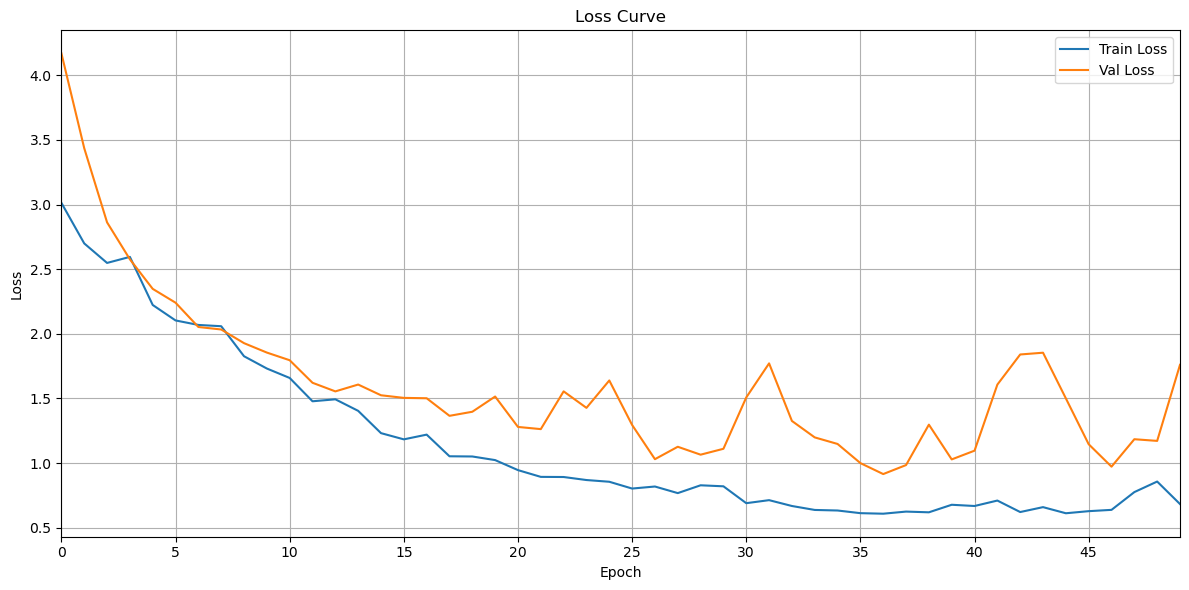

In [13]:
print("***************************************\n")
print(f'The latent dim is {latent_dim}')
print(f'Class weights is {class_weights}')

print("***************************************\n")
evaluate_and_log_model(trainer_cb_2 , dataloaders["test"], seed=42)
print("***************************************\n")
plot_loss(log_paths_2['loss'])

***************************************

The latent dim is 128
Class weights is tensor([1.0000, 1.5000, 1.0000, 3.0000, 3.5000], device='cuda:0')
***************************************

🔒 Random seed set to 42

Evaluation Metrics:
Accuracy: 0.7273
Balanced Accuracy: 0.7640
Macro F1: 0.6676

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.93      0.78        29
           1       0.00      0.00      0.00        15
           2       0.90      1.00      0.95         9
           3       1.00      0.89      0.94         9
           4       0.50      1.00      0.67         4

    accuracy                           0.73        66
   macro avg       0.61      0.76      0.67        66
weighted avg       0.59      0.73      0.64        66


Training Parameters:
{
  "training": {
    "device": "cuda"
  },
  "loss": {
    "type": "MultiOmicsLoss",
    "beta": 0.15,
    "use_focal": true,
    "focal_gamma": 1.3,
    "label_smoothing":

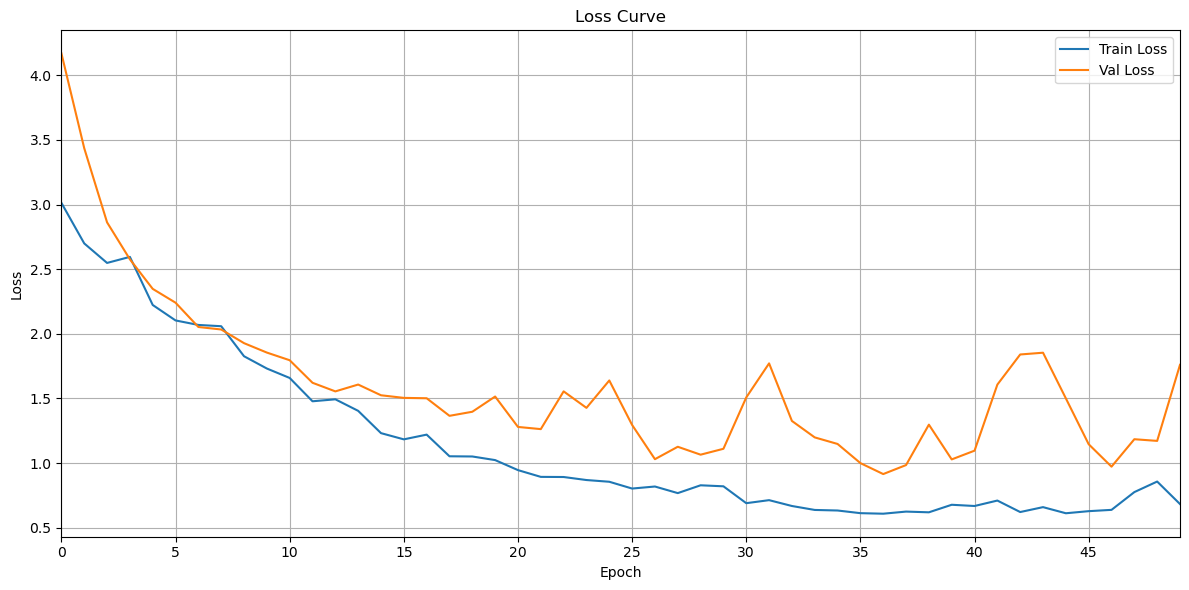

In [14]:
print("***************************************\n")
print(f'The latent dim is {latent_dim}')
print(f'Class weights is {class_weights}')

print("***************************************\n")
evaluate_and_log_model(trainer_cb_2 , dataloaders["test"], seed=42)
print("***************************************\n")
plot_loss(log_paths_2['loss'])

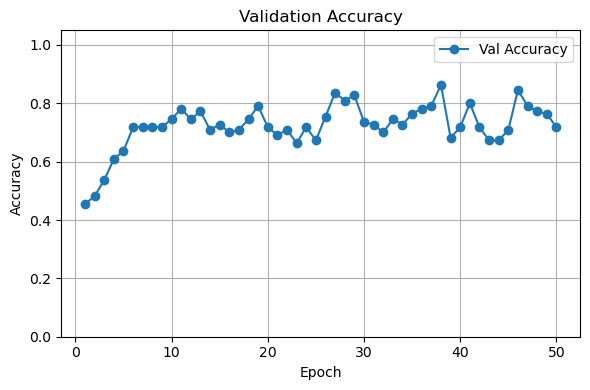

In [15]:
plot_accuracy(log_paths_2['acc'], figsize=(6, 4))

### Training Loss Progression for Breast Cancer Subtype Classification

### Evolution of t-SNE Clusters During Model Training (Breast Cancer Subtypes)

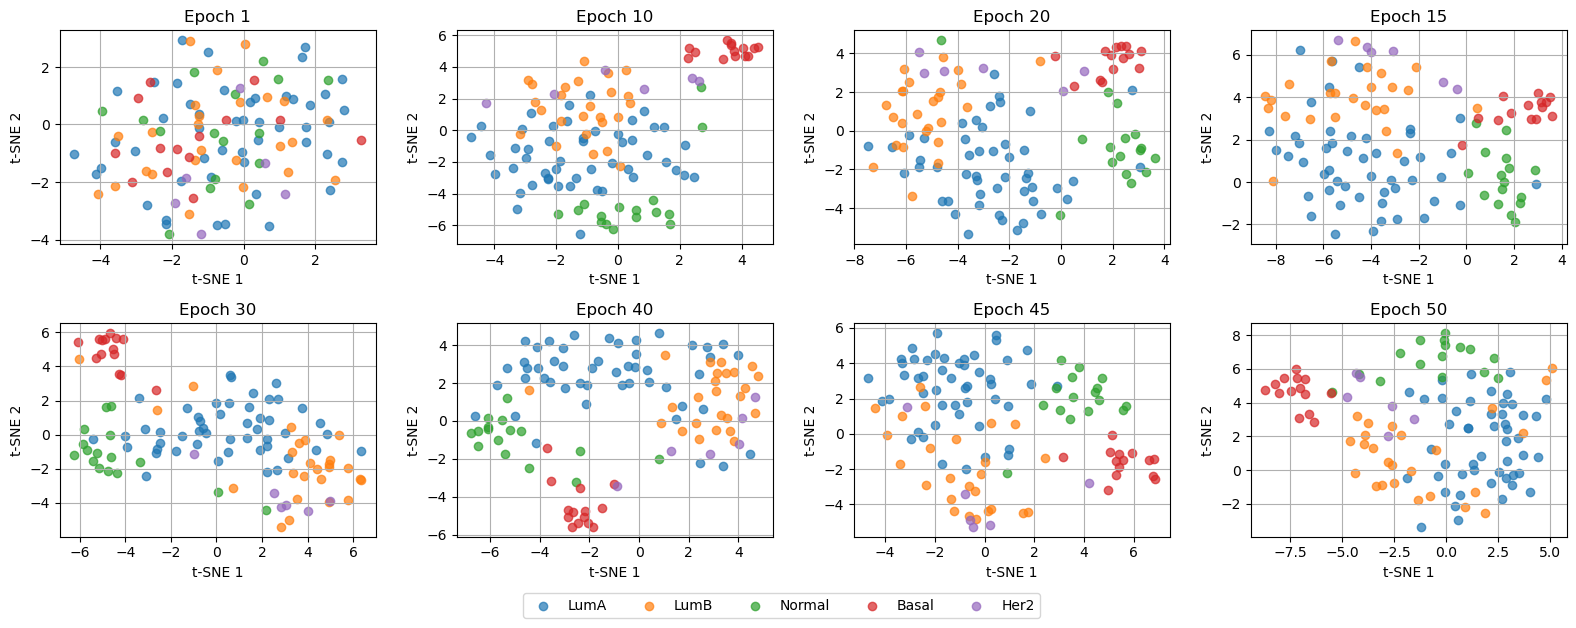

<Figure size 640x480 with 0 Axes>

In [28]:
plot_tsne(tsne_path='logs/experiment_2/tsne_results.pkl', epochs=[1, 10, 20, 15, 30, 40, 45, 50], cols=4, figsize=(4, 3))

plt.savefig("outputs/hw_tsne_epochs.png", dpi=300, bbox_inches='tight')


### Attention weights representing modality-specific contributions to the prediction

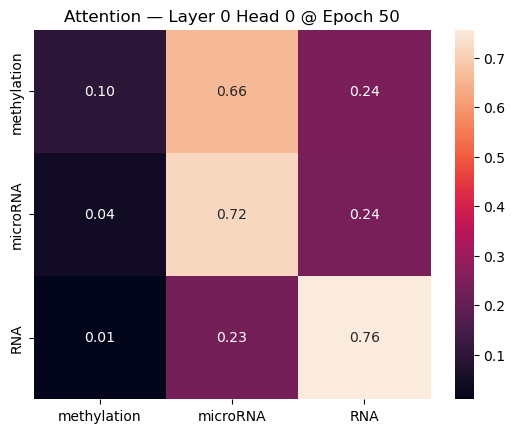

In [17]:


with open("logs/experiment_2/attention_weights.pkl", "rb") as f:
    attention_log = pickle.load(f)

# Example: plot head 0 from layer 0 at epoch 50
last_epoch = attention_log[-1]
weights = last_epoch["attn"][0][0]  # layer 0, head 0
labels = ["methylation", "microRNA", "RNA"]
sns.heatmap(weights, annot=True, fmt=".2f", xticklabels=labels, yticklabels=labels)
plt.title(f"Attention — Layer 0 Head 0 @ Epoch {last_epoch['epoch']}")
plt.show()

### Saliency Map for Identifying the Most Contributory Genes in RNA-Seq Data

In [18]:
#  Inspect file contents

file_npz = "data/clean_data/multimodal_data_features.npz"
with np.load(file_npz, allow_pickle=True) as data:
    print("Available keys:", list(data.keys()))
    print("RNA features shape:", data["rna_features"].shape)

Available keys: ['samples', 'mirna_features', 'rna_features', 'methylation_features', 'class_map', 'metadata']
RNA features shape: (13054,)


In [19]:
# Get gene names and class mapping

with np.load(file_npz, allow_pickle=True) as data:
    gene_names = data["rna_features"]
    class_map = data['class_map']

gene_names, class_map

(array(['?|10357', '?|10431', '?|155060', ..., 'ZZEF1|23140', 'ZZZ3|26009',
        'psiTPTE22|387590'], shape=(13054,), dtype=object),
 array({'LumA': 0, 'LumB': 1, 'Normal': 2, 'Basal': 3, 'Her2': 4},
       dtype=object))

In [20]:
# Calculate average saliency  for RNA data



# 1. Your trained model and test dataloader

multiomics_model_2.eval()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
multiomics_model_2.to(device)

# 2. Compute average saliency for RNA modality
saliency_by_class = compute_average_saliency_by_class(
    model=multiomics_model_2,
    dataloader=dataloaders['test'],
    modality_key='rna',           # or 'mirna', 'methyl'
    max_per_class=50,
    device=device
)

In [21]:
# Convert saliency map to dataframe

id_to_type = {v:k for k, v in class_map.item().items()}
df_saliency_by_class = pd.DataFrame(saliency_by_class, index=gene_names).rename(columns=id_to_type)
df_saliency_by_class

,LumB,LumA,Basal,Normal,Her2
?|10357,0.000885,0.000507,0.000385,0.000189,0.000476
?|10431,0.000351,0.000252,0.000915,0.000243,0.000391
?|155060,0.000798,0.000640,0.000409,0.000330,0.000450
?|57714,0.000584,0.000587,0.000311,0.000447,0.000414
?|653553,0.001079,0.000749,0.000294,0.000285,0.000127
...,...,...,...,...,...
ZYG11B|79699,0.000251,0.000308,0.000575,0.000390,0.000158
ZYX|7791,0.000534,0.000608,0.000370,0.000449,0.000213
ZZEF1|23140,0.000683,0.000394,0.000247,0.000104,0.000672
ZZZ3|26009,0.001582,0.000931,0.000472,0.000240,0.001011


In [22]:
top5_by_class = {cls: df_saliency_by_class[cls].nlargest(5).index.tolist()
                 for cls in df_saliency_by_class.columns}

bottom5_by_class = {cls: df_saliency_by_class[cls].nsmallest(5).index.tolist()
                    for cls in df_saliency_by_class.columns}

In [23]:
def split_gene(gene_series):
    """Vectorized gene name splitter (handles entire Series at once)"""
    return gene_series.str.split("|", expand=True)[0]

# Process all classes at once using apply
def process_class(class_saliency):
    top = split_gene(class_saliency.nlargest(5).index.to_series()).tolist()
    bottom = split_gene(class_saliency.nsmallest(5).index.to_series()).tolist()
    return top, bottom

results = df_saliency_by_class.apply(process_class)

# Convert to DataFrame with better formatting
df_summary = pd.DataFrame([
    {
        "Subtype": cls,
        "Top 5 Genes": ", ".join(top),
        "Bottom 5 Genes": ", ".join(bottom)
    }
        for cls, (top, bottom) in results.items()
])

In [24]:
df_summary

,Subtype,Top 5 Genes,Bottom 5 Genes
0,LumB,"MRPS30, TMEM11, STARD3, DDO, GRB7","C1orf77, NNMT, HYOU1, RTN4R, SP4"
1,LumA,"MRPS30, GRB7, KRT7, KRT80, NUDT8","ROMO1, EEF1E1, B2M, CYC1, GPX8"
2,Basal,"SCNN1A, DUS4L, SERHL2, SLC44A4, C8orf83","FYN, SERPINF1, FYB, HLA-DRA, DEXI"
3,Normal,"KRT80, NPC1, KRT7, FBXL22, OXTR","EHMT2, FKBPL, PPP1R3D, CHSY1, PRDX4"
4,Her2,"SERHL, FOXC1, STARD3, PGAP3, BRAF","ZNF586, KLHL36, PKDCC, XAF1, PIN1"


In [25]:
# Apply styling with renamed headers

display_df = df_summary.rename(columns={
    "Top 5 Genes": "Most Contributing Genes",
    "Bottom 5 Genes": "Least Contributing Genes"
})

styled_table = (
    display_df.style
    .set_table_styles([
        # 1. Top border
        {"selector": "", "props": [("border-top", "2px solid black !important")]},
        # 2. Header bottom border
        {"selector": "thead th", "props": [("border-bottom", "1px solid black !important")]},
        # 3. Bottom border
        {"selector": "", "props": [("border-bottom", "2px solid black !important")]},
        # Cell formatting
        {"selector": "th, td", "props": [
            ("padding", "8px"),
            ("text-align", "left"),
            ("border", "none !important")
        ]}
    ])
    .hide(axis="index")
    .set_caption("Most and Least Contributory Genes for Breast Cancer Subtype Prediction")
    .set_properties(**{'border-collapse': 'collapse'})
    # Rename columns for display only
    .set_table_styles([
        {"selector": "th.col_heading.level0", "props": [("font-weight", "bold")]},
    ], overwrite=False)
)

# Rename headers in the display (without changing DataFrame)


# Display in Jupyter
display(styled_table)



Subtype,Most Contributing Genes,Least Contributing Genes
LumB,"MRPS30, TMEM11, STARD3, DDO, GRB7","C1orf77, NNMT, HYOU1, RTN4R, SP4"
LumA,"MRPS30, GRB7, KRT7, KRT80, NUDT8","ROMO1, EEF1E1, B2M, CYC1, GPX8"
Basal,"SCNN1A, DUS4L, SERHL2, SLC44A4, C8orf83","FYN, SERPINF1, FYB, HLA-DRA, DEXI"
Normal,"KRT80, NPC1, KRT7, FBXL22, OXTR","EHMT2, FKBPL, PPP1R3D, CHSY1, PRDX4"
Her2,"SERHL, FOXC1, STARD3, PGAP3, BRAF","ZNF586, KLHL36, PKDCC, XAF1, PIN1"


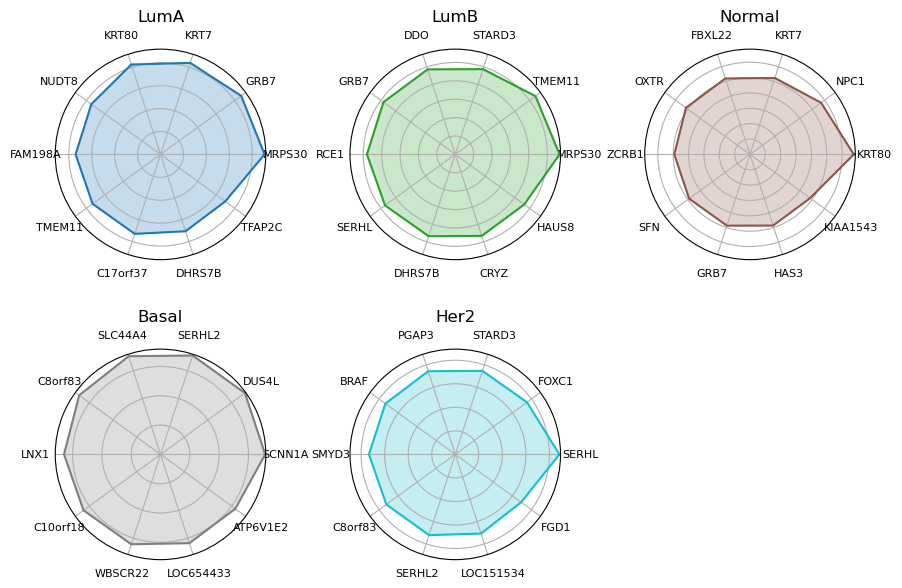

In [26]:
# Check the most 

plot_saliency_radar(
    class_saliency=saliency_by_class,
    top_n=10,  # or 15
    gene_names=[gene.split("|")[0] for gene in gene_names],
    id_to_type=id_to_type,
    ncol=3, figsize=(10, 10)
)